# Functions

In [7]:
%run "../Notebooks/initialization.ipynb"
%run "../Notebooks/Input_selection_functions.ipynb"
%run "../Notebooks/Downsampling_and_outliers_functions.ipynb"
%run "../Notebooks/Stitching_clean.ipynb"
%run "../Notebooks/Visualization_functions.ipynb"
%run "../Notebooks/Evaluation_functions.ipynb"

%load_ext autoreload

loading directory file
----------------------------------------
loaded variables from initialization file: 
> myparams, myconfiguration_file
> list_picked_id_source, list_picked_id_target
> data_folder
----------------------------------------
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# default
all_paths_images,all_paths_ply, num_images,labels,img_folder,ply_folder,all_images,all_ply = load_input(data_folder)

default set:
-imgfolder, contains 30 images 
-plyfolder, contains 30 ply  
found labels file: 
['External', 'Internal', 'Upper']


In [3]:
## uncomment following line to select different ply and img folders as input
#all_paths_images,all_paths_ply,num_images,labels,img_folder,ply_folder,,all_images,all_ply = select_input_files(data_folder)

# Sort sequences appropriately

Given the initial 10 teeth: 
- external im# Sort sequences appropriately

In the first set of teeth we got 30 images in sequences of 10:
- seq_1: external images are sorted as 0 to 9
- seq_2: internal images are sorted as 9 to 0
- seq_3: upper images are sorted as 0 to 9

In the second set of teeth we got 20 images in sequences of 10:
- seq_1: external images are sorted as 0 to 9
- seq_2: internal images are sorted as 9 to 0

The data is taken with a intradental camera which moves from one side to the other of the mounth, with small movements (2-5mm) which need to guarantee enough overlapping between the pictures/point clouds to allow proper reconstruction. 

From a quick look at the pictures we notice that we always need to reverse the order of the second sequence (seq_1) images and ply (done at the beginning of next notebook).
ages are sorted as 0 to 9
- internal images are sorted as 9 to 0
- upper images are sorted as 0 to 9

need to reverse the order of internal images and ply


In [4]:
num_ply_per_side = 10

In [5]:
# read all ply
all_ply = [o3d.io.read_point_cloud(path) for path in all_paths_ply]

# create sequences of the same lenght
# eg
# seq_0 = external 
# seq_1 = internal
# seq_2 = upper

list_sequences = list(chunks(all_ply, num_ply_per_side))
lseq = len(list_sequences)
print (f"Found {lseq} sequences of {num_ply_per_side} images each")
for s in list(range(1, lseq, 2)):
    ## reverse sequences 1,3,5...
    print (f"Reversed order of sequence {s}")
    list_sequences[s].reverse()
    

Found 3 sequences of 10 images each
Reversed order of sequence 1


# Stitching sequences 

Initially we tried to stitch toghether the point clouds capturing one tooth (one external pcl, one internal and one upper pcl). This was possible, but really unstable: the registration functions would often fall in local minima due to not enough overlapping points.  

Therefore the following successful approach has been implemented, we stich the continuous sequences, and being the point clouds in sequence we expect the overlapping in a proper stitching to be high.
More stable results were obtained,but sometimes we would still get stuck in sub obtimal solution, therefore we put a condition:

>* while result_icp.correspondence_set < 0.7*(len(np.asarray(target.points)))
    * do execute_global_registration
    * do refine_registration

The correspondence set is returned as one of the results of the registration process (both global and icp) and we noticed that when the registration was successful according to a qualitative evaluation (by looking at it)the value of the correspondence set was very high: over a target cloud of ca 20.000 points at least ca 15000 where found overlapping. 

For step by step coomments, please check the function itself under notebook "stitching clean".

Note that:
* prints_statements set to True give the verbose output, in which transformation matrix and metrics are printed.
* Also note that with "visualization on" statement as True, all intermediate results of the stitching are shown ( and you need to close the pop up windows while they appear).
* If the "final_vis_on" is set to True,only the final stitch of one sequence is going to be plotted. 

In the pipeline implementation we will not print one by one the stitching, but here they are for clarity.

In [8]:
#for this_sequence in list_sequences:
t = 0
list_new_pointclouds = []

dt_string = mytimestamp()
mytitle = "PointClouds_%s"%t

for t in tqdm(list(range(9))):
    print(dash)
    mytitle = mytitle +"-%s"%(t+1)
    #print (mytitle)

    if len(list_new_pointclouds) == 0:
        source = list_sequences[0][t]
    else:
        source = list_new_pointclouds[-1]

    target = list_sequences[0][t+1]    
    
    new_source, new_target, newpointcloud ,all_results = stitching_new(
                                                                    #input 
                                                                    source = source, 
                                                                    target = target, 
                                                                    labels= ["%s"%t,"%s"%(t+1)],
                                                                    mytitle = mytitle,
        
                                                                    # cleaning up before stitching
                                                                    add_outlier_removal = False,

                                                                    #downsampling 
                                                                    downsampling_voxel_size = 0.1,
                                                                    limit_size_point_cloud = 30000,

                                                                    #registration
                                                                    voxel_size = 0.2,
                                                                    mmax_iteration = 10**6,
                                                                    mmax_validation = 0.7,

                                                                    # quality control of the stitching
                                                                    myoverlapping_factor = 0.75,
                                                                    maxnumattempts = 10,

                                                                    # visualization and pringtng parameters
                                                                    trans_init = None, # keep the possibility of starting directly the ICP
                                                                    print_statements = False,
                                                                    save_statements = False,
                                                                    visualization_on = False,
                                                                    final_vis_on = False,
                                                                    params = myparams,  
                                                                    configuration_file = myconfiguration_file
                                                                 )

    list_new_pointclouds.append(newpointcloud)

  0%|          | 0/9 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
PointClouds_0-1
--------------------------------------------------------------------------------
PointClouds_0-1-2
--------------------------------------------------------------------------------
PointClouds_0-1-2-3
--------------------------------------------------------------------------------
PointClouds_0-1-2-3-4
--------------------------------------------------------------------------------
PointClouds_0-1-2-3-4-5
--------------------------------------------------------------------------------
PointClouds_0-1-2-3-4-5-6
--------------------------------------------------------------------------------
PointClouds_0-1-2-3-4-5-6-7
--------------------------------------------------------------------------------
PointClouds_0-1-2-3-4-5-6-7-8
--------------------------------------------------------------------------------
PointClouds_0-1-2-3-4-5-6-7-8-9


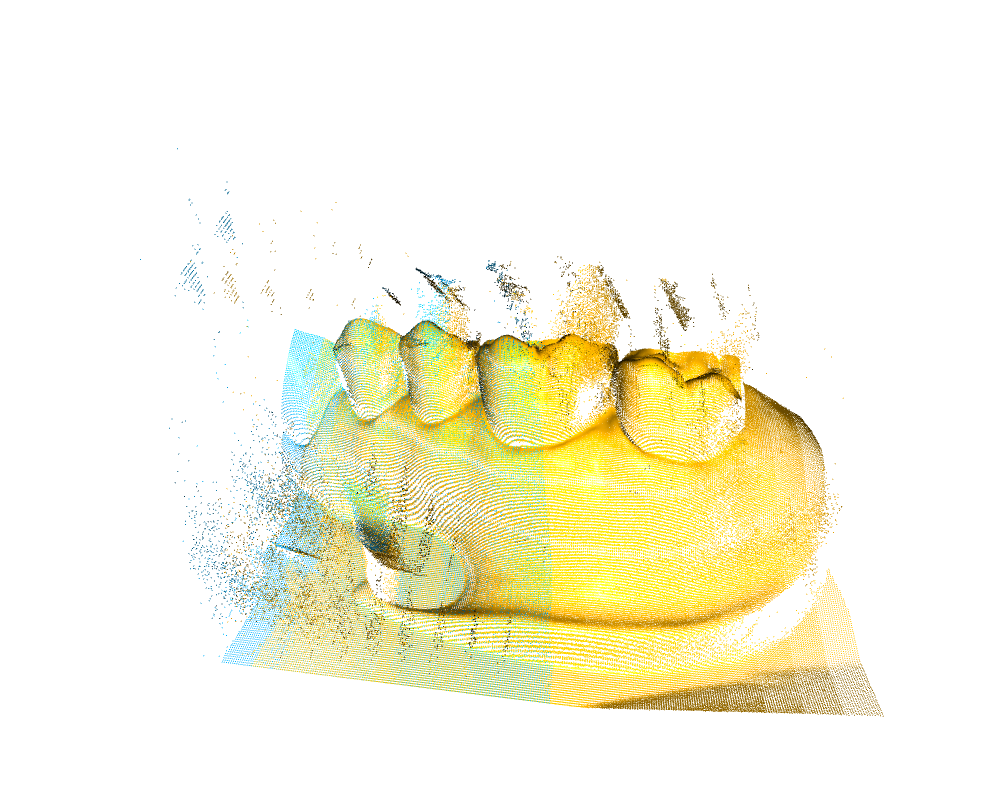

In [9]:
stitched_seq_1 = list_new_pointclouds[-1]
tstring = mytimestamp()

custom_draw_geometry(stitched_seq_1,
                     mytitle = tstring+"stitched_seq_1",
                     params = myparams,  # parameter for camera point view, json file via pressing P
                     configuration_file = myconfiguration_file, # configuration file for properties, json file via pressing o
                     take_screen_shot = True,
                     rotate = False)
# after manual changing in visualization mode
newest = last_file_containing(tstring+"stitched_seq_1", extension = '.png')
Im(filename=newest,width = 800)

In [11]:
#for this_sequence in list_sequences:
t = 0
list_new_pointclouds = []

dt_string = mytimestamp()
mytitle = "PointClouds_%s"%t

for t in tqdm(list(range(9))):
    print(dash)
    mytitle = mytitle +"-%s"%(t+1)
    #print (mytitle)

    if len(list_new_pointclouds) == 0:
        source = list_sequences[1][t]
    else:
        source = list_new_pointclouds[-1]

    target = list_sequences[1][t+1]    
    
    new_source, new_target, newpointcloud ,all_results = stitching_new(
                                                                    #input 
                                                                    source = source, 
                                                                    target = target, 
                                                                    labels= ["%s"%t,"%s"%(t+1)],
                                                                    mytitle = mytitle,
        
                                                                    # cleaning up before stitching
                                                                    add_outlier_removal = False,

                                                                    #downsampling 
                                                                    downsampling_voxel_size = 0.1,
                                                                    limit_size_point_cloud = 30000,

                                                                    #registration
                                                                    voxel_size = 0.2,
                                                                    mmax_iteration = 10**6,
                                                                    mmax_validation = 0.7,

                                                                    # quality control of the stitching
                                                                    myoverlapping_factor = 0.75,
                                                                    maxnumattempts = 10,

                                                                    # visualization and pringtng parameters
                                                                    trans_init = None, # keep the possibility of starting directly the ICP
                                                                    print_statements = False,
                                                                    save_statements = False,
                                                                    visualization_on = False,
                                                                    final_vis_on = False,
                                                                    params = myparams,  
                                                                    configuration_file = myconfiguration_file
                                                                 )

    list_new_pointclouds.append(newpointcloud)

  0%|          | 0/9 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
PointClouds_0-1
--------------------------------------------------------------------------------
PointClouds_0-1-2
--------------------------------------------------------------------------------
PointClouds_0-1-2-3
--------------------------------------------------------------------------------
PointClouds_0-1-2-3-4
--------------------------------------------------------------------------------
PointClouds_0-1-2-3-4-5
--------------------------------------------------------------------------------
PointClouds_0-1-2-3-4-5-6
--------------------------------------------------------------------------------
PointClouds_0-1-2-3-4-5-6-7
--------------------------------------------------------------------------------
PointClouds_0-1-2-3-4-5-6-7-8
--------------------------------------------------------------------------------
PointClouds_0-1-2-3-4-5-6-7-8-9


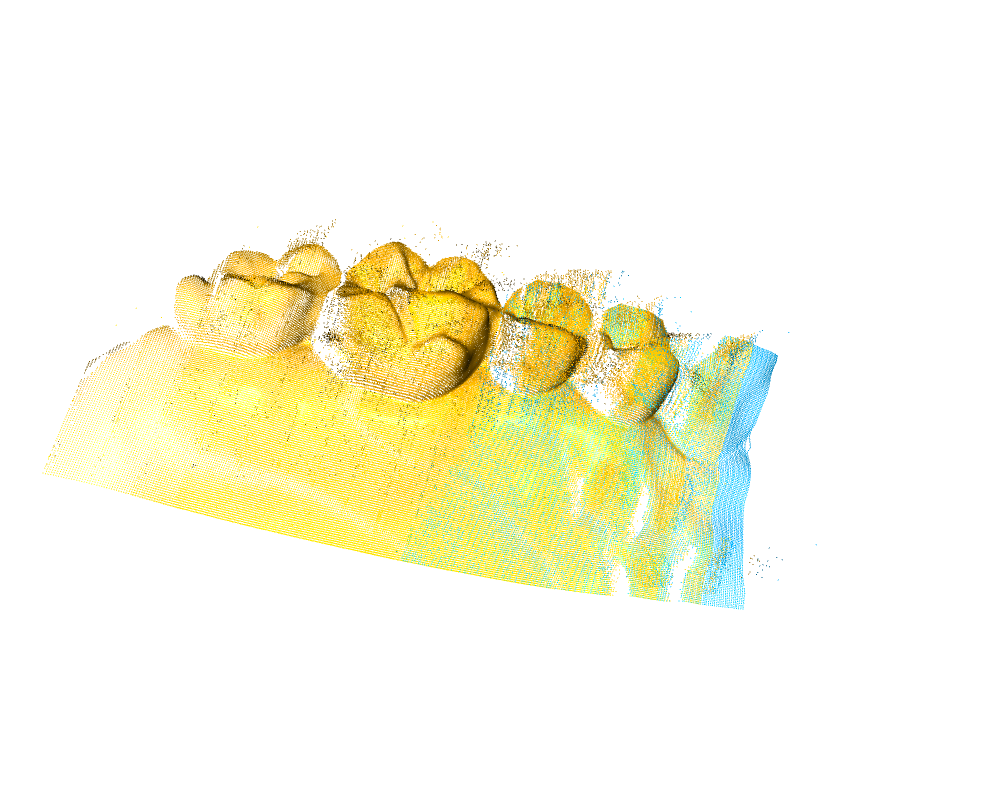

In [12]:
stitched_seq_2 = list_new_pointclouds[-1]
tstring = mytimestamp()

custom_draw_geometry(stitched_seq_2,
                     mytitle = tstring+"stitched_seq_2",
                     params = myparams,  # parameter for camera point view, json file via pressing P
                     configuration_file = myconfiguration_file, # configuration file for properties, json file via pressing o
                     take_screen_shot = True,
                     rotate = False)
# after manual changing in visualization mode
newest = last_file_containing(tstring+"stitched_seq_2", extension = '.png')
Im(filename=newest,width = 800)

In [13]:
#for this_sequence in list_sequences:
t = 0
list_new_pointclouds = []

dt_string = mytimestamp()
mytitle = "PointClouds_%s"%t

for t in tqdm(list(range(9))):
    print(dash)
    mytitle = mytitle +"-%s"%(t+1)
    #print (mytitle)

    if len(list_new_pointclouds) == 0:
        source = list_sequences[2][t]
    else:
        source = list_new_pointclouds[-1]

    target = list_sequences[2][t+1]    
    
    new_source, new_target, newpointcloud ,all_results = stitching_new(
                                                                    #input 
                                                                    source = source, 
                                                                    target = target, 
                                                                    labels= ["%s"%t,"%s"%(t+1)],
                                                                    mytitle = mytitle,
        
                                                                    # cleaning up before stitching
                                                                    add_outlier_removal = True,

                                                                    #downsampling 
                                                                    downsampling_voxel_size = 0.1,
                                                                    limit_size_point_cloud = 30000,

                                                                    #registration
                                                                    voxel_size = 0.2,
                                                                    mmax_iteration = 10**6,
                                                                    mmax_validation = 0.7,

                                                                    # quality control of the stitching
                                                                    myoverlapping_factor = 0.75,
                                                                    maxnumattempts = 10,

                                                                    # visualization and pringtng parameters
                                                                    trans_init = None, # keep the possibility of starting directly the ICP
                                                                    print_statements = False,
                                                                    save_statements = False,
                                                                    visualization_on = False,
                                                                    final_vis_on = False,
                                                                    params = myparams,  
                                                                    configuration_file = myconfiguration_file
                                                                 )

    list_new_pointclouds.append(newpointcloud)

  0%|          | 0/9 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
PointClouds_0-1
--------------------------------------------------------------------------------
PointClouds_0-1-2
--------------------------------------------------------------------------------
PointClouds_0-1-2-3
--------------------------------------------------------------------------------
PointClouds_0-1-2-3-4
--------------------------------------------------------------------------------
PointClouds_0-1-2-3-4-5
--------------------------------------------------------------------------------
PointClouds_0-1-2-3-4-5-6
--------------------------------------------------------------------------------
PointClouds_0-1-2-3-4-5-6-7
--------------------------------------------------------------------------------
PointClouds_0-1-2-3-4-5-6-7-8
--------------------------------------------------------------------------------
PointClouds_0-1-2-3-4-5-6-7-8-9


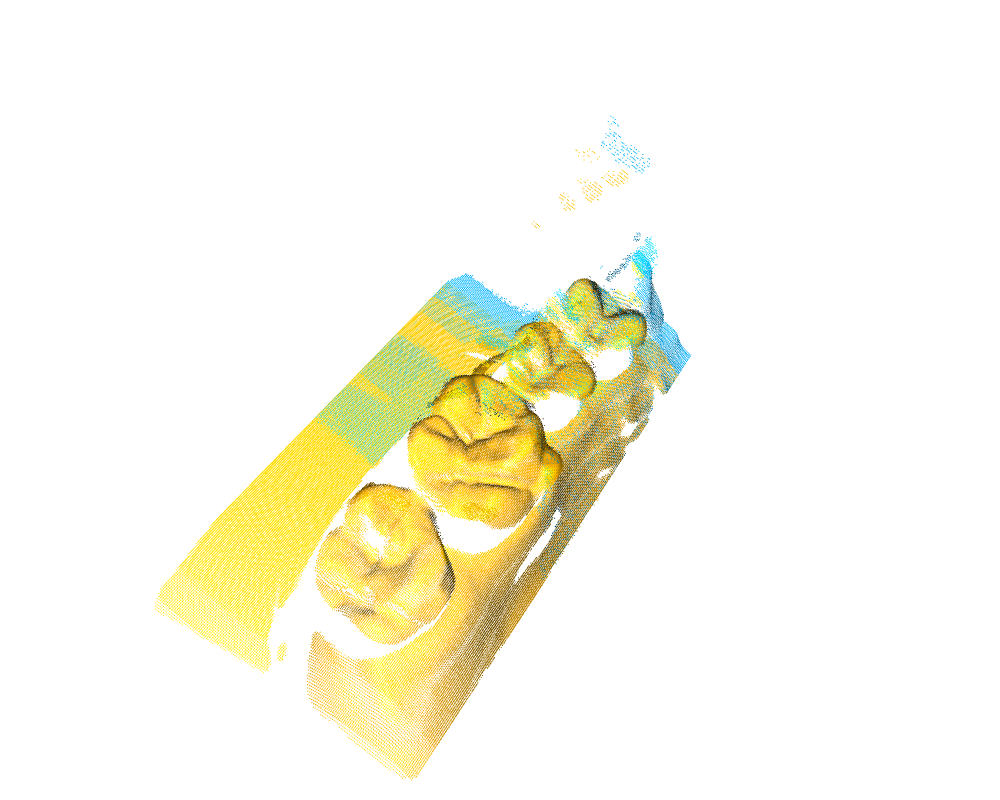

In [14]:
stitched_seq_3 = list_new_pointclouds[-1]
tstring = mytimestamp()

custom_draw_geometry(stitched_seq_3,
                     mytitle = tstring+"stitched_seq_3",
                     params = myparams,  # parameter for camera point view, json file via pressing P
                     configuration_file = myconfiguration_file, # configuration file for properties, json file via pressing o
                     take_screen_shot = True,
                     rotate = False)
# after manual changing in visualization mode
newest = last_file_containing(tstring+"stitched_seq_3", extension = '.png')
Im(filename=newest,width = 800)

In [15]:
all_stitched_sequences = [stitched_seq_1.paint_uniform_color([0.5, 0.4, 0.0]),
                          stitched_seq_2.paint_uniform_color([0.0, 0.4, 0.5]),
                          stitched_seq_3.paint_uniform_color([0.3, 0.0, 0.5])
                         ]

## results visualizations

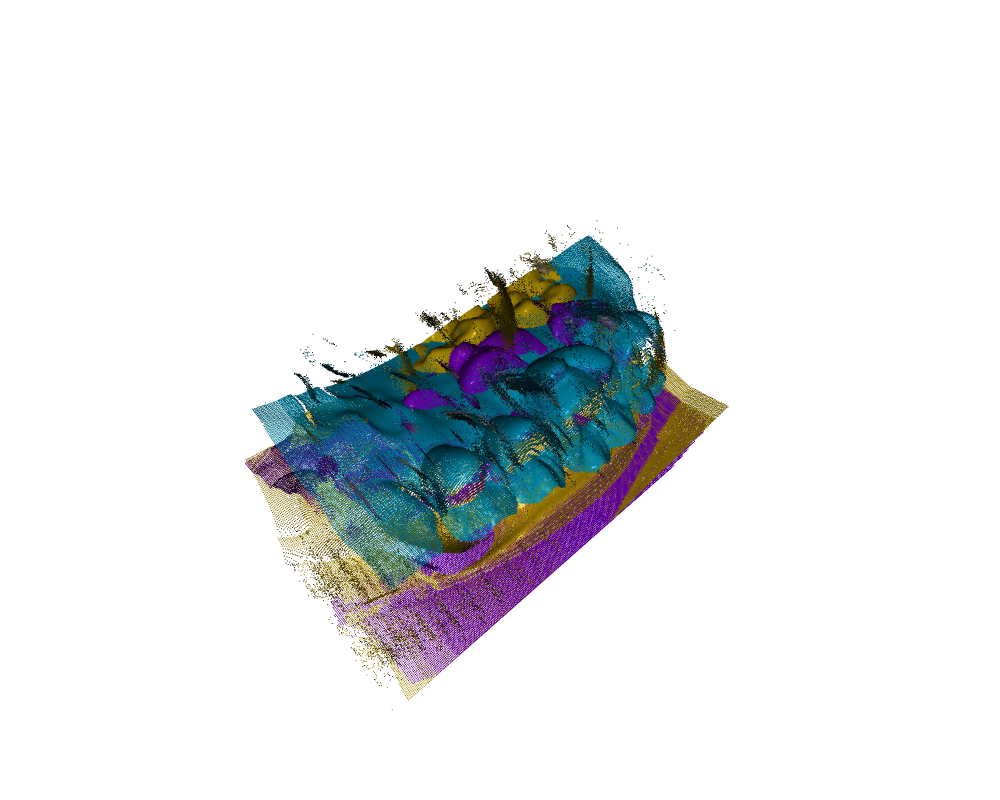

In [16]:
## all together
tstring = mytimestamp()
custom_draw_geometry(
                     stitched_seq_1+stitched_seq_2+stitched_seq_3,
                     mytitle = tstring+"all_three_sequences",
                     params = myparams,  # parameter for camera point view, json file via pressing P
                     configuration_file = myconfiguration_file, # configuration file for properties, json file via pressing o
                     take_screen_shot = True,
                     rotate = False,
                     onewindow = True
                    )
# after manual changing in visualization mode
newest = last_file_containing(tstring+"all_three_sequences", extension = '.png')
Im(filename=newest,width = 800)

## store locally

official and backup with timestamp

In [17]:
tstring = mytimestamp()
for i, seq in enumerate(all_stitched_sequences):
    o3d.io.write_point_cloud(dt_string+"stitched_seq_%s.pcd"%i, seq)
    